# ROC Curves

<img src="https://kaggle2.blob.core.windows.net/competitions/inclass/4050/media/AUC.jpeg"/, width="500">
The ROC (Receiver Operating Characteristic) curve or ROC curve is a plot with the True Positive Rate (Sensitivity) on the y-axis, and the False Positive Rate (1 - Specificity) on the x-axis.


    True Positive Rate: TP / (TP + FN) [aka. Recall]
    False Positive Rate: 1 - TN/(TN + FP) = FP/(FP + TN)

---
per Wiki:
A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.

-----

The 'ideal' decision boundary provided by logistic regression is the boundary at which the probability of binary classes are even (i.e. P(A) == P(A') )

We can modulate the threshold for acceptance if we want a higher or lower True Positive Rate, traded off for a higher or lower False Positive Rate.

-----

The dotted line in an ROC curve represents when TPR == FPR. Models with curves above this line imply models better than random, while lines below the line imply models worse than random choice. 


The AUC (Area Under Curve) is the integral of the ROC curve. It can be used as a rough comparison measure when comparing multiple classifiers. An AUC of 1 implies a perfect model (i.e. the integral == 1 across the entire curve). In addition, AUC is a better metric than Accuracy for imbalanced classes. 

-----





# Heart Disease


The following dataset is a set of data from the UCI data storage. Patients who visited Cleveland hospitals had 76 attributes about them collected, as well as the number of heart diseases they had.

Typically, only 14 of the attributes have been used for learning, and rather than predicting how many heart diseases a patient has, we will look at the presence or absence of heart disease.



[UCI Heart Disease Link](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)


** Unlike in lecture 8, we would like to compare multiple models' performance using the ROC curve and AUC **

In [33]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [34]:
features = ["age","sex","cp","trestbps","chol","fbs",
           "restecg","thatlach","exang","oldpeak","slope",
           "ca","thal","num"]
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",names=features  )

In [35]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thatlach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [36]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thatlach,exang,oldpeak,slope,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [37]:
#looks like issues with ca and thal columns. let's remove them for now
data = data.drop(['ca','thal'],axis=1)

In [38]:
# Any heart disease amount greater > 0, we'll set to 1.
# This way we have a binary class for "disease" and "no disease"
data.ix[ data.num > 0, 'num'] = 1

In [39]:
## OUTLIER BLOCK , SAVE FOR LATER

#data.head()
#data.loc[303] = pd.Series([100000,0,10,30000,1000000,100,2,1000,0,0,100000,1],index=data.columns)
#data.tail()

In [40]:
# Create our data
X = data.ix[:,:-1]
y = data.num
print 'X:\n',X.head()
print 'y:\n',y[:5]

X:
   age  sex  cp  trestbps  chol  fbs  restecg  thatlach  exang  oldpeak  slope
0   63    1   1       145   233    1        2       150      0      2.3      3
1   67    1   4       160   286    0        2       108      1      1.5      2
2   67    1   4       120   229    0        2       129      1      2.6      2
3   37    1   3       130   250    0        0       187      0      3.5      3
4   41    0   2       130   204    0        2       172      0      1.4      1
y:
0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64


# Model Comparison

We want to compare our classifiers by their accuracy as well as their ROC curves.

To do that, we'll create separate train and test splits (not CV since we want a common test set across all the models).

In practice if you have enough data, you ideally want to have a separate test set. If you need to do cross validation, you can do it within your training set, but the test set should be saved for last and untouched until you have many models to compare.


In [41]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## Logistic Regression

In [42]:
from sklearn import linear_model

model = linear_model.LogisticRegression()
model.fit(X_train,y_train)
y_pred  = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# We are going to pass in the true y, as well as the predicted *PROBABILITIES*
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred_prob[:,1])
roc_auc_lr = metrics.roc_auc_score(y_test,y_pred_prob[:,1]) 

print "Score:",model.score(X_test,y_test), "AUC:", roc_auc_lr

Score: 0.747252747253 AUC: 0.82224428997


## Naive Bayes

In [43]:
from sklearn import naive_bayes

model = naive_bayes.GaussianNB()
model.fit(X_train,y_train)
y_pred  = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

# We are going to pass in the true y, as well as the predicted *PROBABILITIES*
fpr_nb, tpr_nb, thresholds_nb = metrics.roc_curve(y_test, y_pred_prob[:,1])
roc_auc_nb = metrics.roc_auc_score(y_test,y_pred_prob[:,1]) 

print "Score:",model.score(X_test,y_test), "AUC:", roc_auc_nb

Score: 0.692307692308 AUC: 0.808341608739


## K Nearest Neighbors

In [44]:
from sklearn import neighbors
model = neighbors.KNeighborsClassifier()
model.fit(X_train,y_train)
y_pred_prob = model.predict_proba(X_test)

# We are going to pass in the true y, as well as the predicted *PROBABILITIES*
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, y_pred_prob[:,1])
roc_auc_knn = metrics.roc_auc_score(y_test,y_pred_prob[:,1]) 

print "Score:",model.score(X_test,y_test), "AUC:", roc_auc_knn

Score: 0.604395604396 AUC: 0.690417080437


## Plot Out ROC curves

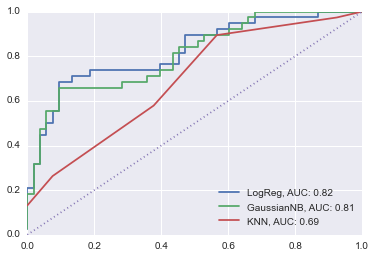

In [45]:
plt.plot(fpr_lr,tpr_lr,label="LogReg, AUC: %.2f" % roc_auc_lr)
plt.plot(fpr_nb,tpr_nb,label="GaussianNB, AUC: %.2f" % roc_auc_nb)
plt.plot(fpr_knn,tpr_knn,label="KNN, AUC: %.2f" % roc_auc_knn)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),":")

plt.legend(loc="best")

## Logistic Regression C Tuning

Perhaps this is because we didn't tune our LogisticRegression regularization parameter, **C**.

If you recall from last lecture, **C** is the inverse of regularization strength. A low C value (just a scalar, no interpretation) corresponds with high regularization. A high C value corresponds with low amounts of regularization.

We can use the provided `LogisticRegressionCV` class, which performs cross validation over a range of C values.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

By default it runs over Cs values of C on a logarithmic scale between 1e-4 and 1e4, though you can provide your own values.

In [46]:
model = linear_model.LogisticRegressionCV(Cs=1000)

model.fit(X_train,y_train)
y_pred  = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)


# We are going to pass in the true y, as well as the predicted *PROBABILITIES*
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred_prob[:,1])
roc_auc_lr = metrics.roc_auc_score(y_test,y_pred_prob[:,1]) 

print "Score:",model.score(X_test,y_test), "AUC:", roc_auc_lr

Score: 0.758241758242 AUC: 0.834657398213


Given the very similar results, I would imagine the betas are regularized in LogisticRegressionCV() to a similar level of the default in LogisticRegression().

## New ROC Curve With CV

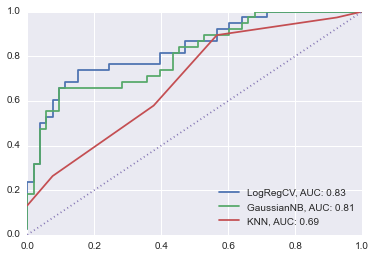

In [47]:
plt.plot(fpr_lr,tpr_lr,label="LogRegCV, AUC: %.2f" % roc_auc_lr)
plt.plot(fpr_nb,tpr_nb,label="GaussianNB, AUC: %.2f" % roc_auc_nb)
plt.plot(fpr_knn,tpr_knn,label="KNN, AUC: %.2f" % roc_auc_knn)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),":")

plt.legend(loc="best")

More information on choosing an 'optimal threshold' 

http://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve

The 'stages' if you will, will be to tune each model individually (if they have tuning parameters such as C or lambda). Then, once you have an optimal model, you compare them to each other on accuracy, ROC curves, and AUC.

The optimal threshold once you have an optimal model is more of a subjective area. For instance, if you choose a higher threshold of acceptance (i.e. higher probability required to predict a "Yes" or "true"), there may be higher financial costs corresponding with this decision.


# Effect of Outliers

There's a commented code block above that adds a single row that is a massive outlier (data entry mistake).

Let's see how our models perform with that outlier